# Analysis of the results

This notebook investigates the results of all the model runs in the directory `results/runs`.

## Imports and hardcoded variables

In [1]:
import os
from functools import partial
from pprint import pprint

import arviz as az
import numpy as np
import pandas as pd
import xarray

from scipy.special import expit
from scipy.stats import norm
from matplotlib import patches
from matplotlib import pyplot as plt


from src.data_preparation import HARDCODED_NUMBERS

RESULTS_DIR = os.path.join("results", "runs")
ARVIZ_STYLE = "default"

## Loading InferenceData objects

The results of the analysis are stored as [`InferenceData`](https://arviz-devs.github.io/arviz/api/generated/arviz.InferenceData.html#arviz.InferenceData) objects in [netcdf](https://www.unidata.ucar.edu/software/netcdf/) files. The next cell loads these files.

In [2]:
run_dirs = [
    os.path.join(RESULTS_DIR, d)
    for d in os.listdir(RESULTS_DIR)
    if os.path.isdir(os.path.join(".", RESULTS_DIR, d))
]
priors = {"old": {}, "new": {}}
posteriors = {"old": {}, "new": {}}

for run_dir in run_dirs:
    dir_name = os.path.basename(run_dir)
    dataset = dir_name.split("_")[-1]
    model_name = "_".join(dir_name.split("_")[:-1])
    prior_file = os.path.join(run_dir, "prior.nc")
    posterior_file = os.path.join(run_dir, "posterior.nc")
    if os.path.exists(prior_file):
        priors[dataset][model_name] = az.from_netcdf(prior_file)
    if os.path.exists(posterior_file):
        posteriors[dataset][model_name] = az.from_netcdf(posterior_file)
        
priors["new"]["angle"]

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [3]:
print("logistic:")
display(az.summary(posteriors["new"]["logistic"]))
print("angle:")
display(az.summary(posteriors["new"]["angle"], var_names="sigma_*", filter_vars="regex"))
print("angle_and_force:")
display(az.summary(posteriors["new"]["angle_and_force"], var_names="sigma_*", filter_vars="regex"))
print("angle_and_force_normal:")
display(az.summary(posteriors["new"]["angle_and_force_normal"], var_names="sigma_*", filter_vars="regex"))

logistic:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.830,0.005,2.821,2.839,0.0,0.0,589.0,532.0,1.0
b,-0.247,0.000,-0.248,-0.246,0.0,0.0,845.0,1209.0,1.0


angle:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_angle,0.048,0.0,0.048,0.048,0.0,0.0,304.0,616.0,1.01
sigma_angle_degrees,2.725,0.0,2.725,2.725,0.0,0.0,307.0,328.0,1.01


angle_and_force:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_angle,0.025,0.012,0.013,0.042,0.006,0.004,5.0,11.0,3.16
sigma_distance,0.112,0.021,0.094,0.138,0.010,0.008,6.0,109.0,1.86
sigma_angle_degrees,1.434,0.667,0.754,2.407,0.332,0.254,5.0,11.0,3.16


angle_and_force_normal:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_angle,0.018,0.000,0.018,0.018,0.0,0.0,1624.0,1659.0,1.0
sigma_distance,0.080,0.001,0.077,0.082,0.0,0.0,1638.0,1907.0,1.0
sigma_y,0.003,0.001,0.002,0.004,0.0,0.0,1750.0,1784.0,1.0
sigma_angle_degrees,1.020,0.006,1.009,1.032,0.0,0.0,1624.0,1659.0,1.0


Some of the runs may also have results of exact cross-validation, also saved in netcdf files. 

While its convenient to store the cross-validation files separately, for analysis it's nice to have them in the same place as their posteriors, so the next cell loads the cross-validation netcdfs and adds them to the matching posterior `InferenceData`s.

In [4]:
for ds, posteriors_ds in posteriors.items():
    for model_name, posterior in posteriors_ds.items():
        llik_cv_file = os.path.join(RESULTS_DIR, model_name + "_" + ds, "llik_cv.nc")
        if os.path.exists(llik_cv_file):
            llik_cv = xarray.load_dataset(llik_cv_file)
            posterior.add_groups({"log_likelihood_cv": llik_cv})
posteriors["new"]["angle"]

/Users/tedgro/.pyenv/versions/3.10.1/lib/python3.10/site-packages/arviz/data/inference_data.py:1361: UserWarning: The group log_likelihood_cv is not defined in the InferenceData scheme
  warnings.warn(


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> log_likelihood_cv

## Comparing predictions

This cell uses arviz's [`compare`](https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html) function to calculate the approximate leave-one-out expected log predictive density for each `InferenceData` object in the `posteriors` dictionary.

It then calculates the same quantity using exact k-fold cross-validation.

In [5]:
posteriors["old"]["angle"].log_likelihood

<xarray.Dataset>
Dimensions:      (chain: 4, draw: 1000, observation: 19)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * observation  (observation) object 'old_0' 'old_1' ... 'old_17' 'old_18'
Data variables:
    llik         (chain, draw, observation) float64 ...
Attributes:
    created_at:     2022-03-25T11:22:31.164885
    arviz_version:  0.12.0

In [6]:
posterior_loo_comparison = {ds: az.compare(posteriors[ds]) for ds in ["old", "new"]}

posterior_kfold_comparison = {
    ds: pd.Series({
        posterior_name: float(
            posterior.get("log_likelihood_cv")["llik"]
            .mean(dim=["chain", "draw"])
            .sum()
        )
        for posterior_name, posterior in ds_posteriors.items() 
        if "log_likelihood_cv" in posterior.groups()
    }, name="kfold")      
    for ds, ds_posteriors in posteriors.items()
}

posterior_comparison = {ds: posterior_loo_comparison[ds].join(posterior_kfold_comparison[ds]) for ds in ["old", "new"]}

print("Prediction comparison on original data:")
display(posterior_comparison["old"])
print("Prediction comparison on new data:")
display(posterior_comparison["new"])

/Users/tedgro/.pyenv/versions/3.10.1/lib/python3.10/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/tedgro/.pyenv/versions/3.10.1/lib/python3.10/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/tedgro/.pyenv/versions/3.10.1/lib/python3.10/site-packages/arviz/stats/stats.py:1047: RuntimeWarning: invalid value encountered in true_divide
  len_scale = n * (np.log(-(b_ary / k_ary)) - k_ary - 1)
/Users/tedgro/.pyenv/versions/3.10.1/lib/python3.10/site-packages/arviz/stats/stats.py:1063: RuntimeWarning

Prediction comparison on original data:


/Users/tedgro/.pyenv/versions/3.10.1/lib/python3.10/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/tedgro/.pyenv/versions/3.10.1/lib/python3.10/site-packages/arviz/stats/stats.py:1080: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/Users/tedgro/.pyenv/versions/3.10.1/lib/python3.10/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/tedgro/.pyenv/versions/3.10.1/lib/python3.10/site-packages/arviz/stats/stats.py:246: RuntimeWarning: divide by zero en

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale,kfold
angle,0,-855.028362,2.032269,0.000000,0.577993,193.368542,0.000000,False,log,-851.103362
angle_and_force,1,-870.794571,26.353169,15.766209,0.000000,202.772955,14.232628,False,log,-846.467013
angle_and_force_normal,2,-888.387022,50.375850,33.358661,0.000000,213.844203,24.587989,True,log,-875.022155
logistic,3,-897.799338,7.585392,42.770977,0.422007,220.004933,40.199455,False,log,-4775.237812


Prediction comparison on new data:


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale,kfold
angle_and_force_normal,0,-316008.209808,1412.020524,0.000000,0.25,69896.626807,0.000000,True,log,-3.152790e+05
logistic,1,-328891.485276,639.770183,12883.275468,0.25,73859.102408,6392.313188,True,log,-2.303742e+06
angle,2,-340502.129506,0.010380,24493.919698,0.25,80772.421527,18727.750917,True,log,-3.384319e+05
angle_and_force,3,-342863.417337,44403.446720,26855.207529,0.25,77253.139773,14530.278814,True,log,-3.218819e+05


## Graphs

To reproduce the graphs from the original paper we first have to reproduce some of the model logic in Python - these are essentially the same functions as can be found in the file `src/stan/custom_funcitons.stan` but non-vectorised.

In [7]:
def f_logistic(x: float, a: float, b: float):
    return expit(a + b * x)


def f_angle(x: float, sigma_angle: float, R: float, r: float):
    return 2*norm.cdf(np.arcsin((R-r) / x) / sigma_angle) - 1


def f_force(x: float, sigma_distance: float, overshot: float, distance_tolerance: float):
    return (
        norm.cdf((distance_tolerance - overshot) / ((x + overshot) * sigma_distance)) 
        - norm.cdf((- overshot) / ((x + overshot) * sigma_distance))
    )

def f_angle_and_force(
    x: float,
    sigma_angle: float, 
    sigma_distance: float,
    R: float,
    r: float,
    overshot: float,
    distance_tolerance: float
):
    p_angle = f_angle(x, sigma_angle, R, r)
    p_force = f_force(x, sigma_distance, overshot, distance_tolerance)
    return p_angle * p_force

The next cell uses these functions to draw graphs comparing the observed relationship between success probability and putting distance with the relationship implied by the marginal posterior mean values of each model's parameters.

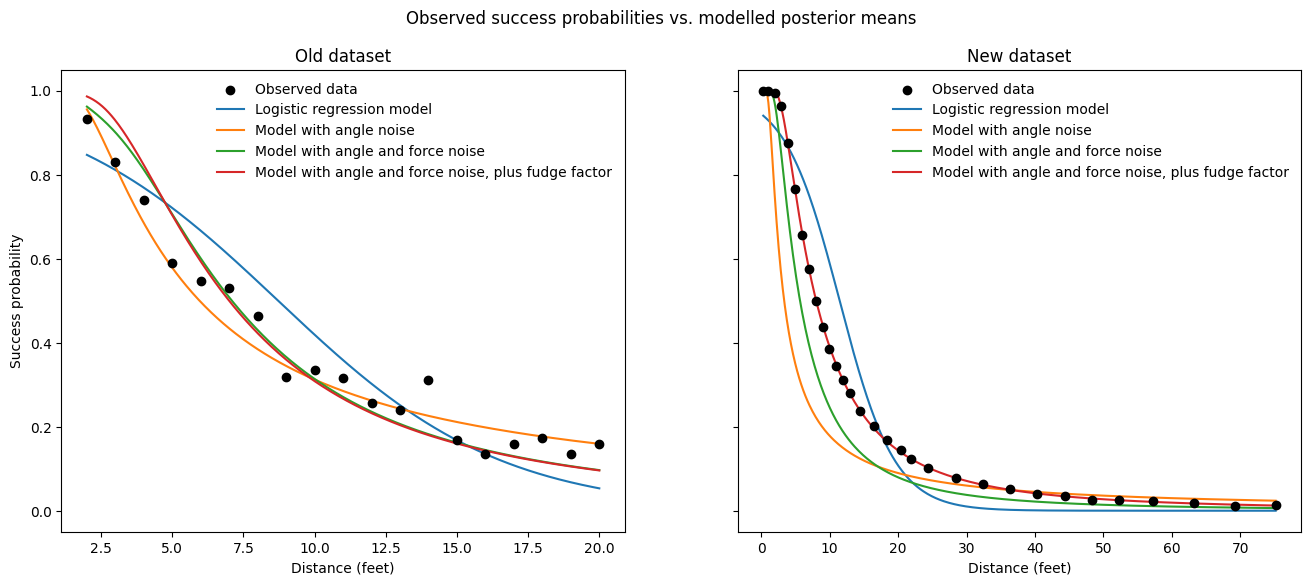

In [8]:
az.style.use(ARVIZ_STYLE)

r = HARDCODED_NUMBERS["r"]
R = HARDCODED_NUMBERS["R"]
overshot = HARDCODED_NUMBERS["overshot"]
distance_tolerance = HARDCODED_NUMBERS["distance_tolerance"]

f, axes = plt.subplots(1, 2, figsize=[16, 6], sharey=True)
ax0ylab = axes[0].set_ylabel("Success probability")
st = f.suptitle("Observed success probabilities vs. modelled posterior means")
    
for ax, (ds, posteriors_ds) in zip(axes, posteriors.items()):
    
    # extract posterior means
    a_mean = posteriors_ds["logistic"].posterior["a"].mean()
    b_mean = posteriors_ds["logistic"].posterior["b"].mean()
    sigma_angle_mean_a = posteriors_ds["angle"].posterior["sigma_angle"].mean()
    sigma_angle_mean_af = posteriors_ds["angle_and_force"].posterior["sigma_angle"].mean()
    sigma_distance_mean_af = posteriors_ds["angle_and_force"].posterior["sigma_distance"].mean()
    sigma_angle_mean_afn = posteriors_ds["angle_and_force_normal"].posterior["sigma_angle"].mean()
    sigma_distance_mean_afn = posteriors_ds["angle_and_force_normal"].posterior["sigma_distance"].mean()
        
    # partial functions
    f_logistic_ds = partial(f_logistic, a=a_mean, b=b_mean)
    f_angle_ds = partial(f_angle, sigma_angle=sigma_angle_mean_a, r=r, R=R)
    f_angle_and_force_ds = partial(
        f_angle_and_force, 
        sigma_angle=sigma_angle_mean_af,
        sigma_distance=sigma_distance_mean_af,
        r=r,
        R=R,
        overshot=overshot,
        distance_tolerance=distance_tolerance
    )
    f_angle_and_force_normal_ds = partial(
        f_angle_and_force,
        sigma_angle=sigma_angle_mean_afn,
        sigma_distance=sigma_distance_mean_afn,
        r=r,
        R=R,
        overshot=overshot,
        distance_tolerance=distance_tolerance
    )
    
    # arrays to plot
    observed_data = posteriors_ds["logistic"].observed_data
    x_mod = np.linspace(observed_data["x"].min(), observed_data["x"].max(), 500)
    x_obs = observed_data["x"].values
    obs = observed_data["y"].values / observed_data["batch_size"].values
    mod_logistic = np.array(list(map(f_logistic_ds, x_mod)))
    mod_angle = np.array(list(map(f_angle_ds, x_mod)))
    mod_angle_and_force = np.array(list(map(f_angle_and_force_ds, x_mod)))
    mod_angle_and_force_normal = np.array(list(map(f_angle_and_force_normal_ds, x_mod)))
    
    # plots
    ax.scatter(x_obs, obs, label="Observed data", color="black", zorder=9)
    ax.plot(x_mod, mod_logistic, label="Logistic regression model")
    ax.plot(x_mod, mod_angle, label="Model with angle noise")
    ax.plot(x_mod, mod_angle_and_force, label="Model with angle and force noise")
    ax.plot(x_mod, mod_angle_and_force_normal, label="Model with angle and force noise, plus fudge factor")
    ax.legend(frameon=False)
    ax.set(title=ds.capitalize() + " dataset", xlabel="Distance (feet)")
    
f.savefig("results/plots/distance.png", bbox_inches="tight")

The last cell reproduces a diagnostic plot from the paper that looks for patterns in the relationship between putting distance and each model's residuals, i.e. the observed minus expected success probability.

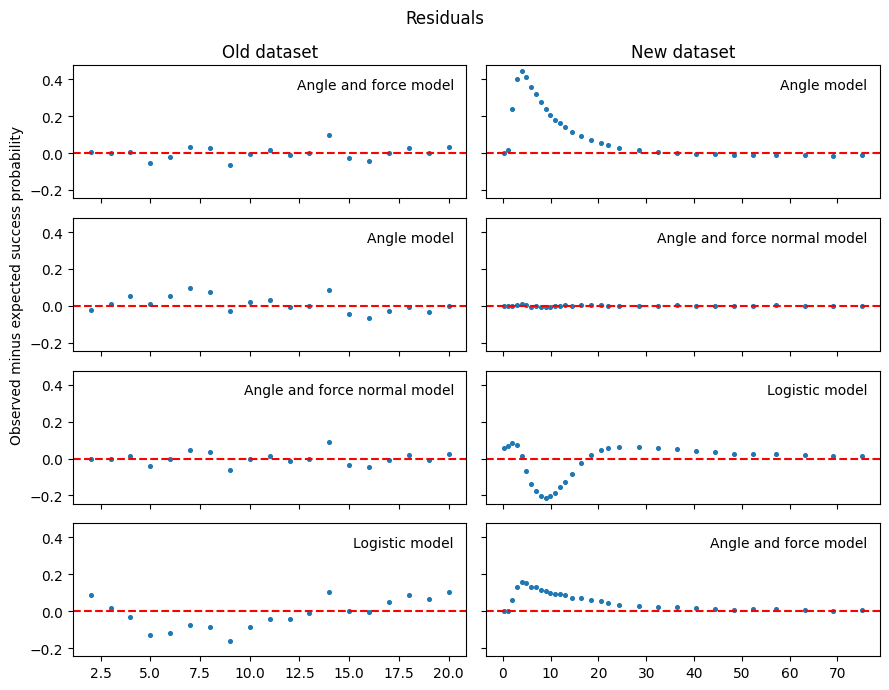

In [9]:
blank_legend_handle = patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none', visible=False)

f, axes = plt.subplots(4, 2, figsize=[9, 7], sharey=True, sharex="col")

f.suptitle("Residuals")
axes[1, 0].set_ylabel("Observed minus expected success probability")

for i, (ds, posteriors_ds) in enumerate(posteriors.items()):
    axes_ds = axes[:, i]
    axes_ds[0].set_title(ds.capitalize() + " dataset")
    observed_data = posteriors_ds["logistic"].observed_data
    x = observed_data["x"].values
    obs = observed_data["y"].values / observed_data["batch_size"].values
    for ax, (model_name, posterior) in zip(axes_ds, posteriors_ds.items()):
        resid = obs - (posterior.posterior_predictive["yrep"] / observed_data["batch_size"]).mean(dim=["chain", "draw"]).values
        ax.scatter(x, resid, s=7)
        ax.legend([blank_legend_handle], [model_name.replace("_", " ").capitalize() + " model"], frameon=False)
        ax.axhline(0, color="red", linestyle="--")
f.tight_layout()
f.savefig("results/plots/residuals.png", bbox_inches="tight")